# Performance and Cost Efficiency

This article aims to provide cost analysis of running big data workloads on the cloud infrastructure along with CPU and storage performance. We began to analyze system limits and pricing information from each cloud provider and tried to indicate accurate performance metrics of different VM server types and storage options across multiple clouds.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.display import display, HTML
%matplotlib inline

## Instance Type

This test was run against AWS and OCI and two server types were selected which have similar number of virtual cores and memory sizes. BM.Standard2.52 is **45%** cheaper than AWS r5.24xlarge according to the pricing and less performance limits are applied.

In [2]:
# CPU Cost
data = {"aws":
        {"type":"r5.24xlarge", 
         "vcpus":96, 
         "mem":"768GB", 
         "processor":"Intel Xeon Platinum 8000 Series",
        "pricing":"$6.048 per Hour"}, 
        "oci":
        {"type":"bm.standard2.52", 
         "vcpus":104,
         "mem":"768GB", 
         "processor":" Intel Xeon Platinum 8167M",
        "pricing":"$3.3176 per Hour"}}
pd.DataFrame.from_dict(data, orient='index')

,type,vcpus,mem,processor,pricing
aws,r5.24xlarge,96,768GB,Intel Xeon Platinum 8000 Series,$6.048 per Hour
oci,bm.standard2.52,104,768GB,Intel Xeon Platinum 8167M,$3.3176 per Hour


### CPU Test

The result indicate similar CPU performance for those two instance types where **684** GFLOPS and **687** GFLOPS are observed by running Python Numpy matrix multiplication. Again BM.Standard2.52 has a cheaper price than r5.24xlarge and it costs only half for 100GFLOPS which is depicted in the following figure.

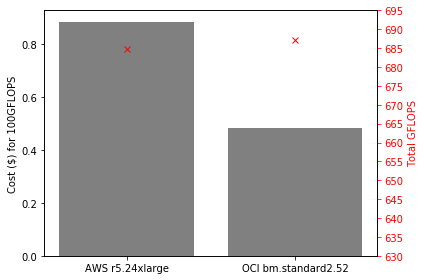

,GFLOPS,Cost for 100GFLOPS (per hour)
aws r5.24xlarge,684.750038,$0.88
oci bm.standard2.52,687.234219,$0.48


In [2]:
fig, ax1 = plt.subplots()

aws_cost_for_100gflops = 6.048/684.7500377387827*100
oci_cost_for_100gflops = 3.3176/687.2342186558482*100

cdata = {"aws r5.24xlarge": 
       {"GFLOPS":684.7500377387827,
       "Cost for 100GFLOPS (per hour)": "$0.88"},
       "oci bm.standard2.52":
       {"GFLOPS":687.2342186558482,
       "Cost for 100GFLOPS (per hour)": "${0:.2f}".format(oci_cost_for_100gflops)}}

ax1.bar([0,1], [aws_cost_for_100gflops, 
                oci_cost_for_100gflops], color='grey')

ax1.set_ylabel('Cost ($) for 100GFLOPS')
ax1.set_xticks([0,1])
ax1.set_xticklabels(["AWS r5.24xlarge", "OCI bm.standard2.52"])

ax2 = ax1.twinx()
ax2.plot([0,1], [684.7500377387827, 687.2342186558482], 'rx')
ax2.set_ylabel('Total GFLOPS', color='r')
ax2.tick_params('y', colors='r')
ax2.set_yticks(np.arange(630, 700, step=5))

fig.tight_layout()
plt.show()

pd.DataFrame.from_dict(cdata, orient='index')

### Block Storage Limit

Storage performance is one of the indicators to find better execution time of workloads especially if they are I/O intensive. Multiple options are available to reduce costs of provisioning high performance storage and several limitations exist based on the type of storage and the type of instance attached. The following table indicates maximum IOPS and throughput for SSD storage options and Google persistent SSD disk and Azure Blob are included as well to show comparable storage choices among others. This will help plan scalable system with performance and to avoid exceeding performance limits where throttling will begin to occur.

The overlooked value is per-instance IOPS and throughput because multiple volumes per instance are more practical ways of building distributed file systems rather than one volume to one instance configuration. In other words, a high IOPS volume attached to a low IOPS instance would not produce its maximum IOPS when throttling occurs at the instance IOPS limit. For example, OCI may generate 800,000 Max IOPS per instance when 32 volumes attached with 25,000 IOPS per volume limit. AWS, however, scales a few times until it reaches the limit of the instance (80,000 - r5.24xlarge) when the limit of the volume (16,000 IOPS - gp2) is provisioned.

In terms of the pricing, OCI is 57.5% cheaper than AWS general purpose SSD (gp2) where \$0.0425 and \$0.1 pricing are suggested respectively.

In [3]:
bdata = {"aws (gp2)":{"media":"ssd",
         "cost": "$0.10 per GB-month",
         "max throughput per volume":"250mib/s",
         "max throughput per instance": "1750mib/s",
         "max IOPS per volume":"16000",
         "max IOPS per instance": "80000",
         "IOPS ratio to volume size (IOPS/GB)": "3:1",
         "Volume size":"up to 16TiB"
        },
         "aws (io1)":{"media":"ssd",
         "cost": "\$0.125 per GB-month, aditional $0.065 per IOPS",
         "max throughput per volume":"1000mib/s",
         "max throughput per instance": "1750mib/s",
         "max IOPS per volume":"64000",
         "max IOPS per instance": "80000",
         "IOPS ratio to volume size (IOPS/GB)": "50:1",
        "Volume size":"up to 16TiB"
        },
          "azure (p50)":{"media":"ssd",
         "cost": "\$0.121 per GB-month, (4 TiB-$495.566/month)",
         "max throughput per volume":"250mib/s",
         "max throughput per instance": "2000mib/s",
         "max IOPS per volume":"7500",
         "max IOPS per instance": "80000",
         "IOPS ratio to volume size (IOPS/GB)": "1.83:1",
        "Volume size":"4TiB"
        },
         
          "azure (p80)":{"media":"ssd",
         "cost": "\$0.055 per GB-month, (32 TiB-$1,802.057/month)",
         "max throughput per volume":"750mib/s",
         "max throughput per instance": "2000mib/s",
         "max IOPS per volume":"20000",
         "max IOPS per instance": "80000",
         "IOPS ratio to volume size (IOPS/GB)": "0.61:1",
        "Volume size":"32TiB"
        },
           "Google":{"media":"ssd",
         "cost": "\$0.17 per GB-month",
         "max throughput per volume":"write: 400mb/s,  read: 1200mb/s",
         "max throughput per instance": "write: 400mb/s, read: 1200mb/s",
         "max IOPS per volume":"write: 30000 read: 60000",
         "max IOPS per instance": "write: 30000 read: 60000",
         "IOPS ratio to volume size (IOPS/GB)": "30:1",
        "Volume size":"up to 60TiB"
        },
        "oci":
        {"media":"ssd",
         "cost":"$0.0425 per GB-month",
         "max throughput per volume":"320mib/s (336mb/s)",
         "max throughput per instance": "-",
         "max IOPS per volume": "25000",
         "max IOPS per instance": "400000",
         "IOPS ratio to volume size (IOPS/GB)": "60:1",
         "Volume size":"up to 32TB"         
        }}
dfbdata=pd.DataFrame.from_dict(bdata, orient='index')
(dfbdata)

,media,cost,max throughput per volume,max throughput per instance,max IOPS per volume,max IOPS per instance,IOPS ratio to volume size (IOPS/GB),Volume size
Google,ssd,\$0.17 per GB-month,"write: 400mb/s, read: 1200mb/s","write: 400mb/s, read: 1200mb/s",write: 30000 read: 60000,write: 30000 read: 60000,30:1,up to 60TiB
aws (gp2),ssd,$0.10 per GB-month,250mib/s,1750mib/s,16000,80000,3:1,up to 16TiB
aws (io1),ssd,"\$0.125 per GB-month, aditional $0.065 per IOPS",1000mib/s,1750mib/s,64000,80000,50:1,up to 16TiB
azure (p50),ssd,"\$0.121 per GB-month, (4 TiB-$495.566/month)",250mib/s,2000mib/s,7500,80000,1.83:1,4TiB
azure (p80),ssd,"\$0.055 per GB-month, (32 TiB-$1,802.057/month)",750mib/s,2000mib/s,20000,80000,0.61:1,32TiB
oci,ssd,$0.0425 per GB-month,320mib/s (336mb/s),-,25000,400000,60:1,up to 32TB


Instance limit obtained from:
- aws: r5.24xlarge
- azure: Standard_M128m
- oci: bm.standard2.52

IOPS based on:
- AWS: 16k block size
- Azure: n/a
- Google: 8k block size
- OCI: 4k block size

Data from:
- Google pricing: https://cloud.google.com/compute/pricing#disk
- Google disk performance: https://cloud.google.com/compute/docs/disks/performance
- OCI Host Maximum: https://blogs.oracle.com/cloud-infrastructure/block-volume-performance-analysis
- AWS: https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/EBSVolumeTypes.html

### IOPS in Detail

IOPS numbers are different based on block size and the IOPS ratio to volume size is related to throughput. High IOPS ratio is better for cost efficiency, otherwise unnecessary volume size need to be provisioned. For example, if 16000 IOPS is offered with 3:1 ratio,  5334GB volume size is at least required to achieve the maximum IOPS.

In [6]:
bdata_iops = {"aws (gp2)" : { "4k": "16,000",
                         "16k": "16,000",
                         "256k": "1,000",
                             },
                "oci" :  { "4k": "25,000",
                          "16k": "16,000",
                          "256k": "1,300"
                             },
             }

                     
bdata_size_req = {"aws (gp2)" : { "4k": "5.3TB",
                         "16k": "5.3TB",
                         "256k": "334GB",
                             },
                "oci" :  { "4k": "417GB",
                          "16k": "667GB",
                          "256k": "417GB"
                             },
             }

dfbdata_iops = pd.DataFrame.from_dict(bdata_iops, orient='index')
dfbdata_size_req = pd.DataFrame.from_dict(bdata_size_req, orient='index')

display(HTML("<h3>IOPS Limit by block size</h3>"))
display(dfbdata_iops)
display(HTML("<h3>Volume size requirement for maximum IOPS</h3>"))
display(dfbdata_size_req)

,4k,16k,256k
aws (gp2),"16,000","16,000","1,000"
oci,"25,000","16,000","1,300"


,4k,16k,256k
aws (gp2),5.3TB,5.3TB,334GB
oci,417GB,667GB,417GB


### OCI IOPS Ratio/Volume Size

This is a note that OCI has a different (calculated) ratio each block size, where AWS provides same IOPS ratio for 4k, 16k, and 256k block sizes.

OCI has different IOPS ratio each block size i.e.
- 60:1 (IOPS:GB) ratio @ 4k
- 30:1 (IOPS:GB) ratio @ 16k
- 2:1 (IOPS:GB) ratio @ 256k

Also note that, 16k block size at OCI does not achieve 320mb/s throughput. Tests indicate 250mb/s.

### Instance Limit

I ran fio I/O benchmark tool to measure instance limits for IOPS and throuput and the following table shows the results where almost no IOPS limit is observed for bm.standard2.52 with 32 volume attachements.

In [7]:
bdata_instance = {"aws i3 series": { "Max Throughput per instance": "1,750MiB/s (7x)",
                                    "Max IOPS per instance":"65,000 (4x)",
                                   "Max Attachments" : 31 },
                  "aws r5 series": {"Max Throughput per instance": "1,750MiB/s (7x)",
                                    "Max IOPS per instance": "80,000 (5x)", 
                                   "Max Attachments" : 28 },
                  "oci bm x7 series": {"Max Throughput per instance": "2,900MiB/s (9x)",
                                      "Max IOPS per instance": "730,000 (29x)",
                                      "Max Attachments" : 32 }
                 }
pd.DataFrame.from_dict(bdata_instance, orient='index')

,Max Throughput per instance,Max IOPS per instance,Max Attachments
aws i3 series,"1,750MiB/s (7x)","65,000 (4x)",31
aws r5 series,"1,750MiB/s (7x)","80,000 (5x)",28
oci bm x7 series,"2,900MiB/s (9x)","730,000 (29x)",32


reference: 
 - aws max attachments: https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/volume_limits.html

## Cost Comparison for Hadoop workloads

According to the pricing above, OCI costs almost half for CPU and block storage. This test is to show actual cost for the five basic hadoop workloads.

COST = CPU TIME + STORAGE TIME

COST = (instance price \* number of nodes / 3600 second (in an hour) \* execution time in second) + STORAGE TIME

COST = CPU TIME +  (volume price \* provisioned volume size \* number of volumes used / 2592000 second (in a month) \* execution time in second)

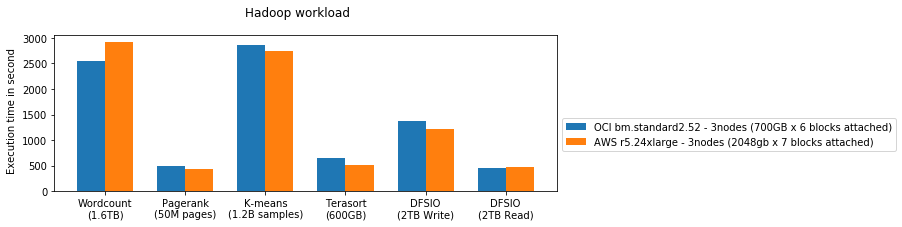

,aws,oci
Wordcount\n(1.6TB),2917.403,2552.655
Pagerank\n(50M pages),427.872,498.668
K-means\n(1.2B samples),2733.394,2868.367
Terasort\n(600GB),517.907,643.867
DFSIO\n(2TB Write),1214.513,1380.916
DFSIO\n(2TB Read),479.424,446.619


In [9]:
# wordcount, pagerank, kmeans, terasort, dfsio write, dfsio read
hadoop_index = ('Wordcount\n(1.6TB)', 'Pagerank\n(50M pages)', 'K-means\n(1.2B samples)', 'Terasort\n(600GB)', 'DFSIO\n(2TB Write)', "DFSIO\n(2TB Read)")
aws_bigdata_elapsed = (48 * 60 + 37.403, 7 * 60 + 7.872, 2733.394, 8 * 60 + 37.907, 1214.513, 479.424)
oci_bigdata_elapsed = (42 * 60 + 32.655, 8 * 60 + 18.668, 2868.367, 10 * 60 + 43.867, 1380.916, 446.619)
ind = np.arange(len(aws_bigdata_elapsed))

fig, axs = plt.subplots(1, 1, figsize=(9, 3),sharex=False, sharey=True)
fig.suptitle("Hadoop workload")
fig.subplots_adjust(top=0.85, hspace=0.5)
fig.text(0.06, 0.5, 'Execution time in second', ha='center', va='center', rotation='vertical')

width = 0.35
idx=0
axs.bar(ind - width/2, oci_bigdata_elapsed, width, label="OCI bm.standard2.52 - 3nodes (700GB x 6 blocks attached)")
axs.bar(ind + width/2, aws_bigdata_elapsed, width, label="AWS r5.24xlarge - 3nodes (2048gb x 7 blocks attached)")
axs.set_xticks(ind)
axs.set_xticklabels(hadoop_index)
axs.legend(loc='upper left', bbox_to_anchor=(1, 0.5))


plt.show()

df_hadoop = pd.DataFrame({'oci': oci_bigdata_elapsed,
                         "aws": aws_bigdata_elapsed}, index=hadoop_index)
display(df_hadoop)

The execution time for both AWS and OCI shows similar results in the current system setup. Note that more blocks with larger volume size were attached to AWS for at least 40000 IOPS per instance.

If the formula above is applied to the wordcount, AWS costs \$14.7 for CPU TIME and \$1.61 for STORAGE TIME whereas OCI costs \$ 7.06 for CPU TIME and \$ 0.176 for STORAGE TIME.

### Notes

- AWS offers per-second billing